# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load the libraries as required.
# Load essential libraries
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

import shap



/Users/kate/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi',
    'temp', 'rh', 'wind', 'rain', 'area'
]
fires_dt = pd.read_csv('../../05_src/data/fires/forestfires.csv', header=0, names=columns)

# Remove zero-area rows to balance predictions
fires_dt = fires_dt[fires_dt['area'] > 0]

fires_dt['log_area'] = np.log1p(fires_dt['area'])





# Get X and Y

Create the features data frame and target data.

In [4]:
X = fires_dt.drop(columns=['area', 'log_area', 'coord_x', 'coord_y'])
y = fires_dt['log_area']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
num_features = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_features = ['month', 'day']

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [6]:
preproc1 = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [7]:
# Preprocessor 2: Power Transform (for skewed data) + Standard Scaling + OneHotEncoding
preproc2 = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', PowerTransformer())
    ]), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [8]:
# Define Models
# baseline_model = Ridge()
# advanced_model = RandomForestRegressor(n_estimators=100, random_state=42)


In [9]:
# Pipeline A = preproc1 + baseline
pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge())
])



In [10]:
# Pipeline B = preproc2 + baseline
pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])

In [11]:
# Pipeline C = preproc1 + advanced model
pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', GradientBoostingRegressor())
])


In [12]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [13]:
# Define hyperparameter grids
param_grid_ridge = {'regressor__alpha': [0.01, 0.1, 1, 10]}
param_grid_gb = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [5, 10, None]
}

# Perform GridSearchCV
grid_a = GridSearchCV(pipeline_a, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_b = GridSearchCV(pipeline_b, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_c = GridSearchCV(pipeline_c, param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_d = GridSearchCV(pipeline_d, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

# Train models
grids = {'A': grid_a, 'B': grid_b, 'C': grid_c, 'D': grid_d}

for name, grid in grids.items():
    print(f"Training {name}...")
    grid.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid.best_params_}")



Training A...
Best parameters for A: {'regressor__alpha': 0.1}
Training B...
Best parameters for B: {'regressor__alpha': 10}
Training C...
Best parameters for C: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 50}
Training D...
Best parameters for D: {'regressor__max_depth': 5, 'regressor__n_estimators': 100}


# Evaluate

+ Which model has the best performance?

In [15]:
pip install matplotlib`

/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file
Note: you may need to restart the kernel to use updated packages.


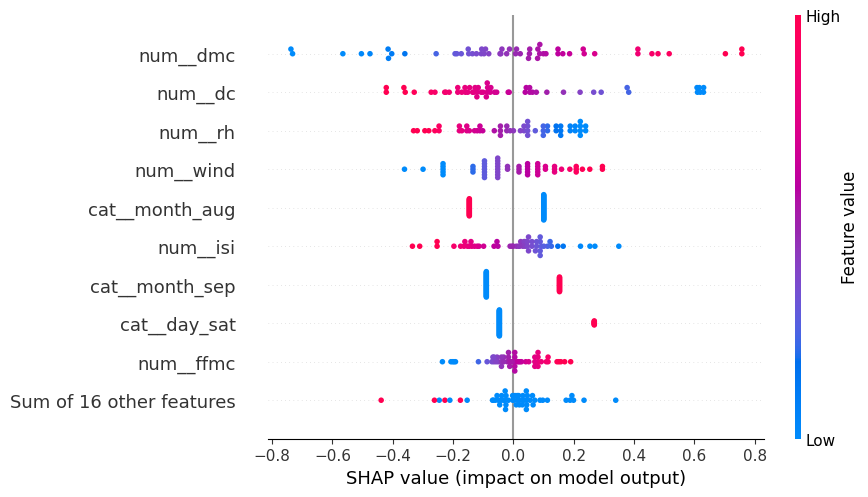

Least Important Features:
           Feature  SHAP Importance
15  cat__month_may     0.000000e+00
8   cat__month_apr     0.000000e+00
7        num__rain     1.882650e-18
10  cat__month_dec     1.621530e-03
21    cat__day_sun     4.895328e-03
11  cat__month_feb     6.366694e-03
14  cat__month_mar     6.832560e-03
13  cat__month_jun     7.549393e-03
24    cat__day_wed     1.119972e-02
16  cat__month_oct     1.161096e-02

Most Important Features:
           Feature  SHAP Importance
22    cat__day_thu         0.036636
0        num__ffmc         0.073220
20    cat__day_sat         0.079428
17  cat__month_sep         0.113184
3         num__isi         0.113880
9   cat__month_aug         0.119180
6        num__wind         0.124366
5          num__rh         0.140118
2          num__dc         0.217000
1         num__dmc         0.245159


In [20]:
# Load best model
with open("best_model.pkl", "rb") as file:
    best_model = pickle.load(file)

# Get feature names from preprocessing step
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Transform X_test
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)

# Explain model predictions using SHAP
explainer = shap.Explainer(best_model.named_steps['regressor'], X_test_transformed, feature_names=feature_names)
shap_values = explainer(X_test_transformed)

# Plot feature importance
shap.plots.beeswarm(shap_values)

# Identify least important features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='SHAP Importance', ascending=True)

print("Least Important Features:")
print(importance_df.head(10))

print("\nMost Important Features:")
print(importance_df.tail(10))


# Export

+ Save the best performing model to a pickle file.

In [17]:
# Identify the best model based on GridSearch scores
best_model = max(grids.items(), key=lambda x: x[1].best_score_)[1]

# Save the best model
with open("best_model.pkl", "wb") as file:
    pickle.dump(best_model.best_estimator_, file)

print("Best model saved as 'best_model.pkl'.")

Best model saved as 'best_model.pkl'.


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

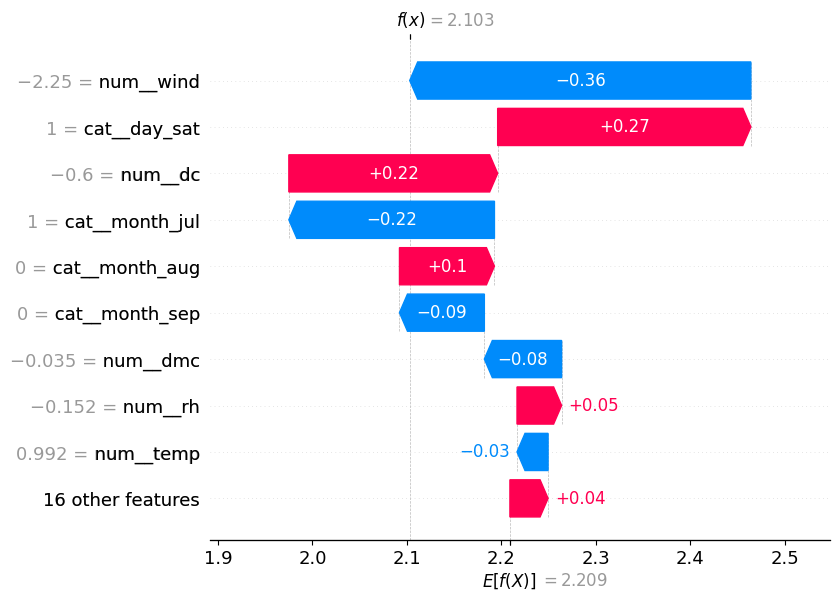

In [22]:
# Select a random test observation (e.g., index 5)
obs_idx = 5
obs_transformed = X_test_transformed[obs_idx].reshape(1, -1)

# Get SHAP values for this observation
obs_shap_values = explainer(obs_transformed)

# Waterfall plot for local explanation
shap.plots.waterfall(obs_shap_values[0])


*(Answer here.)*

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.